# sentencePiece로 네이버 영화 리뷰 감정 분석

## 분석 모델의 목적 

네이버 영화 댓글로 구성된 데이터를 input으로 받으면, 긍정적인 반응(label 1) 인지 부정적인 반응(label 2) 인지인지 판단. 

이미 exp node 4에서 KoNLPY의 형태소 분석기를 사용해서 텍스트를 전처리했었음.

이번 프로젝트에서는 tokenizer를 sentencepiece로 바꾸어서 다시 풀어보아 성능을 비교하는 것이 목적.

In [14]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [16]:
print(type(raw))

<class 'list'>


In [19]:
raw2.tolist

<class 'numpy.ndarray'>


## SentencePiece 설치

SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것임.  

* [google/sentencepiece](https://github.com/google/sentencepiece)

SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 **표준**의 역할을 하고 있음. 

 SentencePiece는 python에서 전용 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있음.
 
``` terminal 
$ pip install sentencepiece
```

In [ ]:
## SentencePiece 모델 학습

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentbence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))


## Tokenizer 함수 작성

>
> 1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.
>
> 2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word > 사전을 생성하고 함께 반환합니다.
> 
> 3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

## 데이터 전처리 

In [80]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [78]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print(train_data.info(),"\n-----------------------------------\n",train_data.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None 
-----------------------------------
          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


train data는 0부터 149999 즉 150000개가 있습니다.            
데이터는 index, id, document,label로 이루어져있는것을 확인 할 수 있었습니다. 

In [54]:
raw = train_data['document'].values
raw = raw.tolist()

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


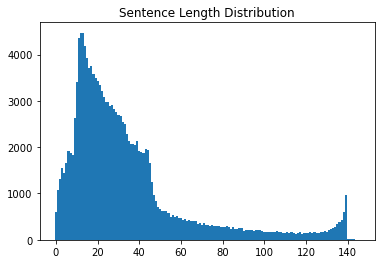

In [55]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


댓글이다 보니 짧은 리뷰들이 많은 것을 확인할 수 있습니다. 

In [63]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        sen = str(sen)
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [66]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 156:
        print("Outlier Index:", idx+1)
        

Outlier Index: 1
Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
O

In [65]:
check_sentence_with_length(raw, 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


Data Size: 146183
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


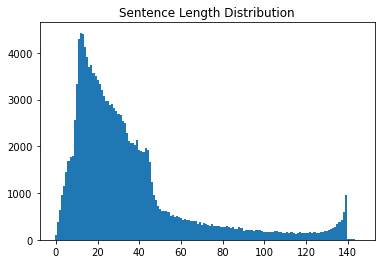

In [68]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


150000개의 데이터에서 중복을 줄이자 146183를 얻을 수 있었습니다.

짧은 문장은 뻬고 139 길이까지의 문장만 사용하도록 하겠습니다.

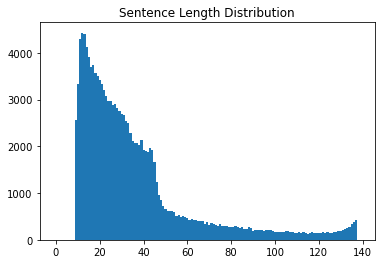

In [71]:
max_len = 139
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(str(s)) < max_len) & (len(str(s)) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


In [72]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [73]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


-rw-r--r-- 1 ssac4 ssac4 374947  4월 18 19:34 korean_spm.model
-rw-r--r-- 1 ssac4 ssac4 144420  4월 18 19:34 korean_spm.vocab


In [76]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentbence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1407, 10, 389, 15, 1340, 10, 139, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [74]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word


In [81]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 575 2905   13 1155 2303    4    0    0    0    0]
 [1466 2438  312  570   10    3   16 7935  853    8]]


## SentencePiece 모델 학습

In [84]:
tensor , word_index, index_word = sp_tokenize(s, filtered_corpus)

## 2. 데이터로더 구성


나만의 data_loader를 만들어 보는 것으로 시작합니다.           
data_loader에서 수행해야할 것들은 아래와 같습니다.

* 데이터의 중복 제거                                   
* NaN 결측치 제거         
* 한국어 토크나이저로 토큰화                     
* 불용어(Stopwords) 제거                 
* 사전word_to_index 구성                 
* 텍스트 스트링을 사전 인덱스 스트링으로 변환                    
* X_train, y_train, X_test, y_test, word_to_index 리턴                         

In [92]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #정규식으로 한글이 아닌것은 제거 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규식 한글이 아닌것은 제거
    train_data['document'].replace('', np.nan, inplace=True) #공백값만 존재하면 nan로 변경
    test_data['document'].replace('', np.nan, inplace=True) # 공백값만 존재하면 nan로 변경
    train_data = train_data.dropna(how = 'any')  # na값 제거 
    test_data = test_data.dropna(how = 'any')  #na값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

load_data함수를 만든이후 함수를 통해
X_train, y_train,X_test, y_test, word_to_index를 원본 train_data,test_data에서 읽어왔습니다. 

In [93]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [94]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

그후 word_to_index를 이용하여 반대로 index_to_word를 만들었고,      
encode,decode 데이터 역시 만들 수 있었습니다. 

In [95]:
print(X_train[0])
print(X_train[:3])

print(len(X_train))
print(len(X_test))
print(len(X_train+X_test))



[27, 67, 895, 33, 214, 15, 28, 699]
[[27, 67, 895, 33, 214, 15, 28, 699], [977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364], [19, 192, 2]]
145791
48995
194786


여러 전처리를 끝낸후 X_train은 145791, X_test는 48995가 되었음을 확인 할 수 있었습니다. 

아마 여러분들은 네이버 영화리뷰 감정분석 태스크를 한 번쯤은 다루어 보았을 것입니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

학습된 모델로 sp_tokenize() 메소드 구현하기

구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

(보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

## 루브릭

|평가문항|상세기준|
|--|--|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|